In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.features import build_features

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)


In [23]:
df_diagnosticos = pd.read_csv(
    "../data/processed/datos_limpios_diagnosticos.csv", encoding="latin-1", sep=";"
)
df_diagnosticos = build_features.formatear_fechas_ambulatorio(df_diagnosticos)
df_diagnosticos = build_features.agregar_rango_etario(df_diagnosticos)
df_diagnosticos["mes"] = df_diagnosticos.fecha_atencion.dt.month
df_diagnosticos["dia"] = df_diagnosticos.fecha_atencion.dt.day

El rango de fechas de diagnosticos es entre 2016-01-04 08:00:00 y  2023-02-07 11:50:03


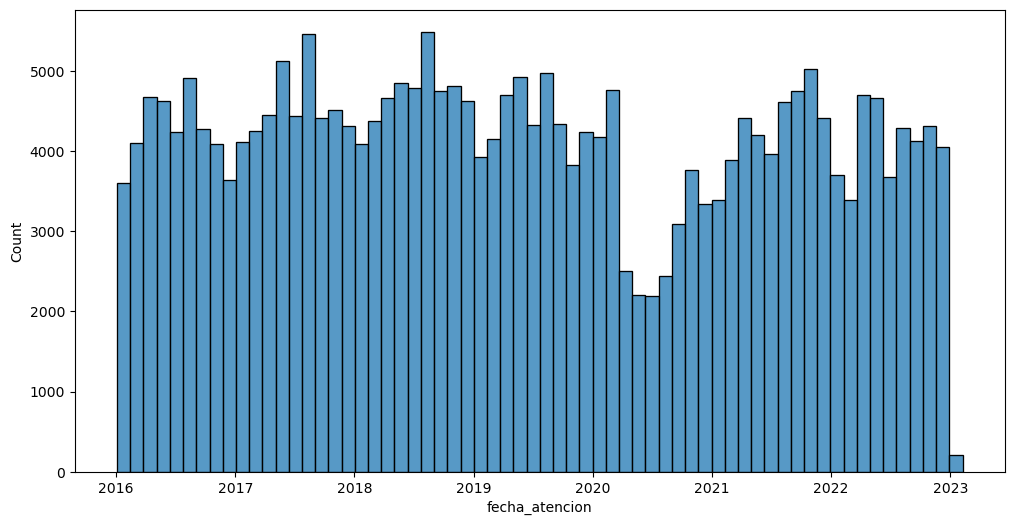

In [34]:
print(
    f"El rango de fechas de diagnosticos es entre {min(df_diagnosticos.fecha_atencion)} y "
    f" {max(df_diagnosticos.fecha_atencion)}"
)
sns.histplot(df_diagnosticos["fecha_atencion"])
plt.show()

In [35]:
df_procedimientos = pd.read_csv(
    "../data/processed/datos_limpios_procedimientos.csv", encoding="latin-1", sep=";"
)
df_procedimientos["fecha_realizacion"] = pd.to_datetime(
    df_procedimientos.fecha_realizacion, yearfirst=True, errors="coerce"
)
df_procedimientos["ano"] = df_procedimientos.fecha_realizacion.dt.year.astype("Int16")
df_procedimientos["mes"] = df_procedimientos.fecha_realizacion.dt.month.astype("Int16")
df_procedimientos["dia"] = df_procedimientos.fecha_realizacion.dt.day.astype("Int16")

El rango de fechas de procedimientos es entre 2020-01-01 00:00:00 y  2022-08-31 00:00:00


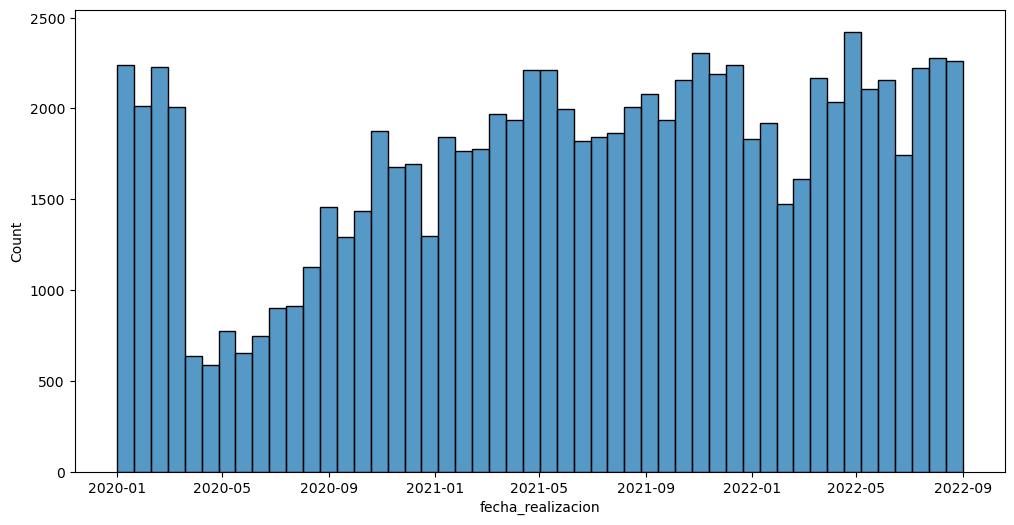

In [36]:
print(
    f"El rango de fechas de procedimientos es entre {min(df_procedimientos.fecha_realizacion)} y "
    f" {max(df_procedimientos.fecha_realizacion)}"
)
sns.histplot(df_procedimientos["fecha_realizacion"])
plt.show()

# Analisis a lo largo del tiempo

En este analisis se quieren obtener los siguientes insights:

- Frecuencia de diagnosticos por anio
- Rango etario por anio
- Procedencias por anio
- Sexo por anio

In [5]:
desglose_sociodemografico = ["ano"]

variables_a_analizar = ["codigo_diagnostico", "sexo", "rango_etario_primera_consulta"]


In [6]:
resultados_sociodemo = build_features.obtener_dfs_para_desglose_sociodemografico(
    df_diagnosticos, desglose_sociodemografico, variables_a_analizar, "codigo_diagnostico"
)

In [7]:
with pd.ExcelWriter("../data/processed/tableros_powerbi/distribucion_sociodemografica.xlsx") as file:
    for nombre_hoja, df_a_guardar in resultados_sociodemo.items():
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja, index=False)

# Analisis de procedimientos y diagnosticos

- En este apartado se quiere realizar un analisis de cuales procedimientos se le realizan a cada
diagnostico en ambulatorios. La primera forma de resolverlo es de la siguiente forma:

    - Se enlaza por el ID del paciente y la fecha de realizacion de la consulta/procedimiento. Esto
    asume que dentro de la consulta se realizo un procedimiento. Por ejemplo: Paciente X con fecha 
    de consulta el 21-07-2022 y fecha de procedimiento el 21-07-2022. En lo anterior se enlaza y 
    se obtiene la dulpa diagnostico/procedimiento.

In [8]:
df_diagnosticos_2020 = df_diagnosticos.query("ano >= 2020 and ano <= 2022").set_index(
    ["ano", "mes", "dia", "id_paciente"]
)
df_procedimientos = df_procedimientos.set_index(["ano", "mes", "dia", "id_paciente"])

In [22]:
df_procedimientos.reset_index()[["ano", "mes"]].value_counts(sort=False)

ano   mes
2020  1      3549
      2      2943
      3      2363
      4      1044
      5      1068
      6      1124
      7      1545
      8      1860
      9      2179
      10     2498
      11     2636
      12     2540
2021  1      2624
      2      2366
      3      3402
      4      3260
      5      3286
      6      3068
      7      2811
      8      3172
      9      3127
      10     3314
      11     3523
      12     3508
2022  1      2793
      2      2139
      3      3440
      4      3187
      5      3452
      6      3197
      7      3200
      8      3737
dtype: int64

In [11]:
print(f"La base de datos de consultas entre 2020 y 2022 tiene {df_diagnosticos_2020.shape[0]} consultas")
print(f"La base de datos de consultas entre 2020 y 2022-08 tiene {df_sticos_2020.shape[0]} consultas")

La base de datos de consultas entre 2020 y 2022 tiene 104274 consultas


In [9]:
union = pd.merge(
    df_diagnosticos_2020, df_procedimientos, left_index=True, right_index=True, how="inner"
)

In [10]:
df_diagnosticos_2020

codigo_reserva_atencion  \
ano  mes dia id_paciente                                                                   
2021 8   19  f40c6ba5a6d3716592b54a7aff31bf554e97d7f2a5f7b27...               1000170481   
2020 1   14  a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...               1000301829   
             a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...               1000301829   
     2   24  7cd7289e0bee9f3269004469a387b75cbafb4909bdaf463...               1000318367   
     1   14  bb02393359a7458665f8c79bd56259f8b48b6011822ac83...               1000324743   
...                                                                                  ...   
2022 12  30  9b05878c19b73def1e4bf099ad3a96b85448ce2dff96554...               1000800553   
             a2aea3714d9a7023d6937291df0f03729ff7552abe3e685...               1000800559   
             7aba02debe97629f0a57c1f75f40a7c6f9540be3e5edf33...               1000800564   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...               1000800585   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...               1000800585   

                                                                fecha_nacimiento  \
ano  mes dia id_paciente                                                           
2021 8   19  f40c6ba5a6d3716592b54a7aff31bf554e97d7f2a5f7b27...       1971-01-28   
2020 1   14  a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...       1994-03-08   
             a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...       1994-03-08   
     2   24  7cd7289e0bee9f3269004469a387b75cbafb4909bdaf463...              NaT   
     1   14  bb02393359a7458665f8c79bd56259f8b48b6011822ac83...       2003-09-28   
...                                                                          ...   
2022 12  30  9b05878c19b73def1e4bf099ad3a96b85448ce2dff96554...       1986-03-01   
             a2aea3714d9a7023d6937291df0f03729ff7552abe3e685...       1965-11-25   
             7aba02debe97629f0a57c1f75f40a7c6f9540be3e5edf33...       1938-02-27   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...       1954-11-03   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...       1954-11-03   

                                                                sexo  \
ano  mes dia id_paciente                                               
2021 8   19  f40c6ba5a6d3716592b54a7aff31bf554e97d7f2a5f7b27...    m   
2020 1   14  a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...    m   
             a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c...    m   
     2   24  7cd7289e0bee9f3269004469a387b75cbafb4909bdaf463...    f   
     1   14  bb02393359a7458665f8c79bd56259f8b48b6011822ac83...    m   
...                                                              ...   
2022 12  30  9b05878c19b73def1e4bf099ad3a96b85448ce2dff96554...    f   
             a2aea3714d9a7023d6937291df0f03729ff7552abe3e685...    f   
             7aba02debe97629f0a57c1f75f40a7c6f9540be3e5edf33...    m   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...    m   
             1188671f110b857dd36f21dccc6856bb31c6b886c325c2e...    m   

                                                                      fecha_reserva  \
ano  mes dia id_paciente                                                              
2021 8   19  f40c6ba5a6d3716592b54a7aff31bf554e97d7f2a5f7b27... 2018-01-23 15:15:00   
2020 1   14  a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c... 2020-01-14 14:30:00   
             a3bc4e708114b2e9b1b55b86f3d0852bd22c1d30a68946c... 2020-01-14 14:30:00   
     2   24  7cd7289e0bee9f3269004469a387b75cbafb4909bdaf463... 2019-07-02 14:00:00   
     1   14  bb02393359a7458665f8c79bd56259f8b48b6011822ac83... 2020-01-14 14:30:00   
...                                                                             ...   
2022 12  30  9b05878c19b73def1e4bf099ad3a96b85448ce2dff96554... 2022-12-30 10:00:00   
             a2aea3714d9a7023d6937291df0f03729ff7552abe